In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

In [2]:
from keras import Input
from keras import layers
from tensorflow.keras.optimizers import RMSprop
import random

In [3]:
import sys
sys.path.append('../..')

#import ep.etools as apt

In [4]:
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from tqdm import tqdm

In [26]:
dataCalendar = pd.read_csv('./data/bloc_ttf_calendar_prices.csv')
dataPrices = pd.read_csv('./data/bloc_ttf_prices.csv')
dataPrices[' '] = pd.to_datetime(dataPrices[' '])
dataPrices = dataPrices.set_index(' ')


In [27]:
dataPrices['moy20'] = dataPrices['Day-ahead'].rolling(20).mean()

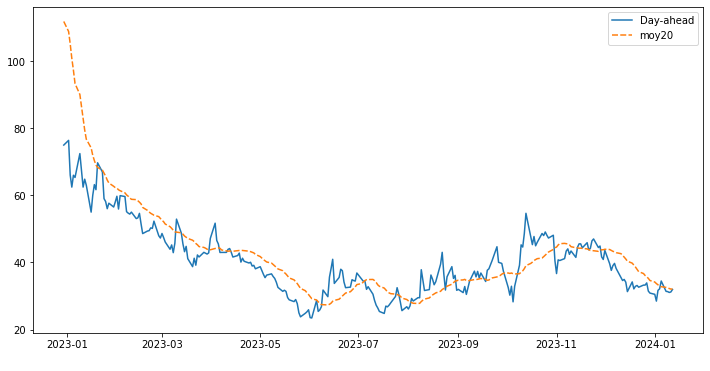

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(dataPrices[['Day-ahead','moy20']][3390:-1], color='Blue');
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')

         Day-ahead  Month-ahead  Quarter-ahead   Summer 24   Winter 24  \
count  3662.000000  3589.000000    2568.000000  650.000000  572.000000   
mean     29.965183    30.930758      35.135822   53.214646   58.340210   
std      32.335071    34.205077      41.192667   27.913017   24.531331   
min       3.110000     3.530000       4.710000   15.960000   22.890000   
25%      16.390000    16.320000      16.015000   32.287500   44.857500   
50%      21.550000    21.720000      19.885000   49.950000   54.215000   
75%      26.367500    26.490000      30.987500   60.822500   63.392500   
max     307.850000   319.360000     344.320000  177.160000  171.080000   

        Year-Ahead  2 Year-Ahead        moy20        delta          abs  
count  3088.000000   3053.000000  3643.000000  3661.000000  3661.000000  
mean     31.853475     27.481271    30.001242     0.185359     3.094583  
std      31.338667     20.343578    31.572644     6.029597     5.177967  
min      11.790000     13.310000     

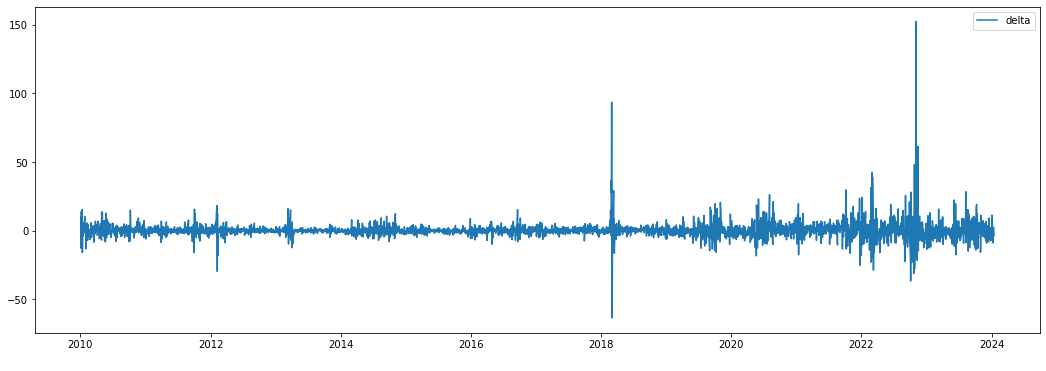

In [37]:
#Variation en %
dataPrices['delta'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0])/x.iloc[0]*100)
dataPrices['abs'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: abs(x.iloc[1] - x.iloc[0])/x.iloc[0]*100)
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(dataPrices[['delta']], color='Blue')
print(dataPrices.describe())


In [39]:
std = dataPrices['abs'].std()
max = dataPrices['abs'].max()
inc = std/10.
print(std,max)

4.42872815588747 28.35820895522389


/Users/rky/miniforge3/envs/tf-M1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


               val         freq
count  1523.000000  1523.000000
mean      0.177282    76.150000
std       0.747371    43.979654
min       0.000000     0.050000
25%       0.000000    38.100000
50%       0.000000    76.150000
75%       0.000000   114.200000
max       8.000000   152.250000
0.05      8
0.15      7
0.25      6
0.35      6
0.45      6
         ..
151.85    0
151.95    0
152.05    0
152.15    0
152.25    0
Name: val, Length: 1523, dtype: int64


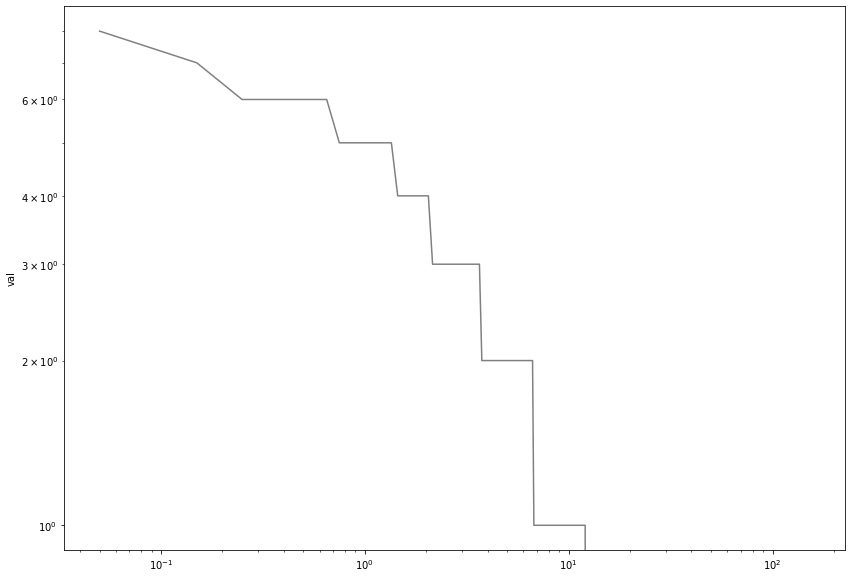

In [38]:
#df= dataPrices['delta'].value_counts(bins=100)
# create intervals
dataPrices = dataPrices[3390:]
bins = pd.interval_range(0, max, freq=0.1)
# assign each value in df["column"] to bin and count bin occurences
counts = pd.cut(dataPrices['abs'], bins).value_counts()
# print(counts.info)
# create a Series, indexed by interval midpoints and convert to dictionary
pdS = pd.Series(counts.values, index=bins.mid).to_frame()   #.to_dict()
pdS['freq'] = pdS.index.values
fig, ax = plt.subplots(figsize=(14,10))
plt.yscale('log')
plt.xscale('log')
pdS = pdS.rename(columns={0:'val'})
sns.lineplot(pdS['val'], color='Grey');
print(pdS.describe())
print(pdS['val'])

In [40]:
distribution = pdS
# distribution = distribution.rename(columns={0:'val'})
# distribution['freq'] = (bins.mid)
distribution['cumul'] = distribution['val'].cumsum(skipna=True)
distribution.reset_index(drop=True,inplace=True)
print(distribution.describe())


               val         freq        cumul
count  1523.000000  1523.000000  1523.000000
mean      0.177282    76.150000   263.131976
std       0.747371    43.979654    30.525021
min       0.000000     0.050000     8.000000
25%       0.000000    38.100000   270.000000
50%       0.000000    76.150000   270.000000
75%       0.000000   114.200000   270.000000
max       8.000000   152.250000   270.000000


        freq  val  cumul
0       0.05    8      8
1       0.15    7     15
2       0.25    6     21
3       0.35    6     27
4       0.45    6     33
...      ...  ...    ...
1518  151.85    0    270
1519  151.95    0    270
1520  152.05    0    270
1521  152.15    0    270
1522  152.25    0    270

[1523 rows x 3 columns]


/Users/rky/miniforge3/envs/tf-M1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rky/miniforge3/envs/tf-M1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


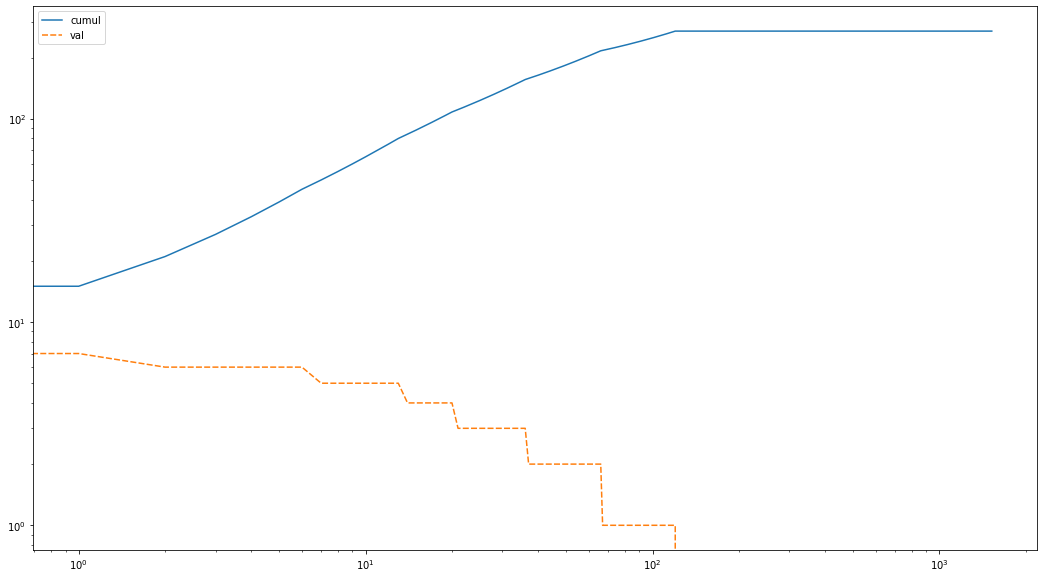

In [41]:
print(distribution[['freq','val','cumul']])
fig=plt.figure(figsize=(18,10))
plt.yscale('log')
plt.xscale('log')
sns.lineplot(distribution[['cumul','val']]);

In [42]:
s = distribution['val'].values[0]
m = distribution['val'].sum()
r = random.randint(0,1700)
min = distribution.index[0]
print(r, m, s)
v = distribution['cumul'].loc[lambda x: x>=r].index.min()
print(v)

1219 270 8
nan


In [43]:
def sign():
    return 1 if random.random() <0.5 else -1

In [44]:
def getRandomValue(df,crit,val,ref):
    nb = df[val].count()
    max = df[crit].max()
    r = (np.random.uniform(0,max))
    s = sign();
    id = df[crit].loc[lambda x: x>=r].index.min()
    if (id>0):
        v = (df[val][id]-df[val][id-1])*(r-df[crit][id-1])/df[ref][id] + df[val][id-1]
    else:
        v = (df[val][id])*r/df[ref][id]
    return s*v

In [45]:
getRandomValue(distribution,'cumul','freq','val')

4.850667830224359

100%|██████████| 1000/1000 [00:00<00:00, 6595.66it/s]


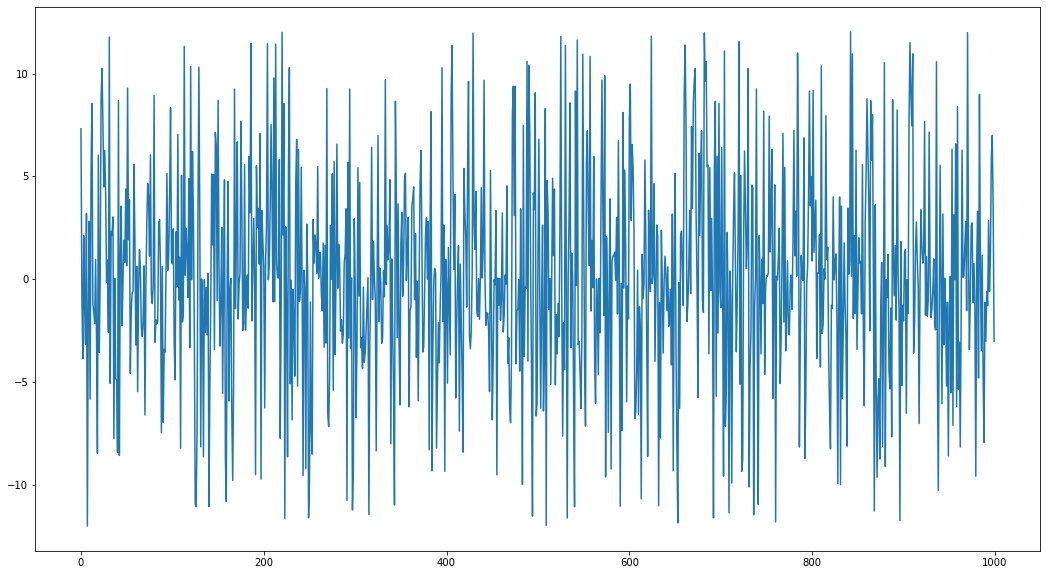

In [46]:
nbEchantillon = 1000
simul = np.ones(nbEchantillon)
for i in tqdm(range(nbEchantillon)):
    simul[i] = (getRandomValue(distribution,'cumul','freq','val'))
    
fig = plt.figure(figsize=(18,10))
plt.plot(simul);

In [47]:
#distribution.reset_index(drop=True,inplace=True)
#distribution.set_index()
distribution.iloc[55]

val        2.00
freq       5.55
cumul    194.00
Name: 55, dtype: float64

In [48]:
from pandas.tseries.offsets import DateOffset,BusinessDay

100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


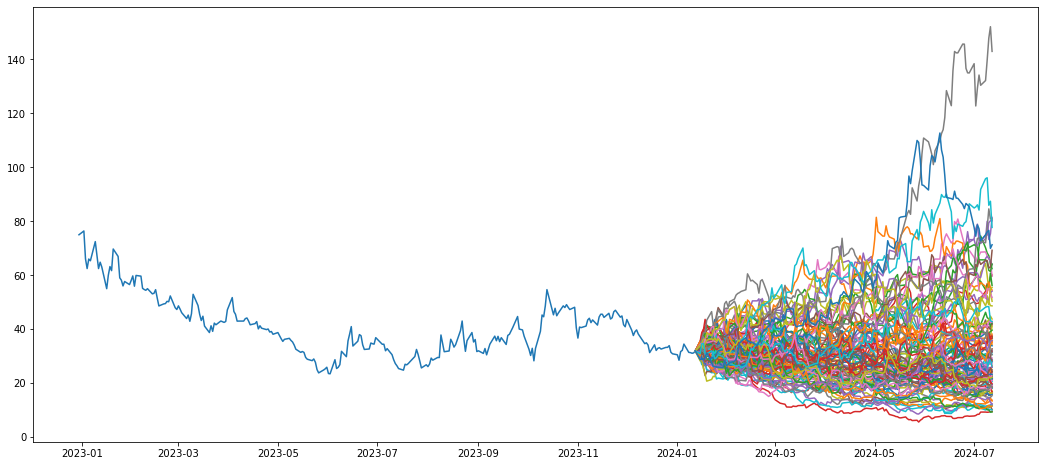

In [62]:
nbEchantillon = 130
ancData = dataPrices['Day-ahead'][0:-1]
# print(startVal, startDate)
startVal = ancData[-1]
startDate = ancData.index[-1]
for i in tqdm(range(100)):
    val = startVal
    date = startDate
    simul = pd.Series([startVal],index=[startDate]);
    for i in range(nbEchantillon):
        val = (1 + getRandomValue(distribution,'cumul','freq','val')/100) * val;
        date = date + BusinessDay(1)
        simul[date] = val
    ancData = pd.concat([ancData,simul],axis=1)
fig = plt.figure(figsize=(18,8))
plt.plot(ancData);

33.39292291659821 60.29363124402542


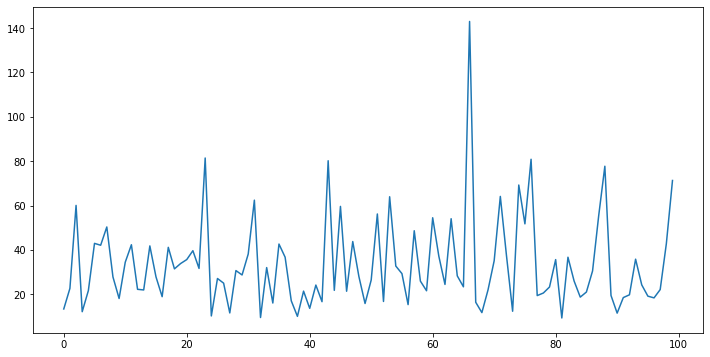

In [64]:
end = ancData.index[-1]
# val = ancData.loc[startDate+BusinessDay(10)].values
val = ancData.loc[end].values
# val[~np.isnan(val)]
val = val[1:]
fig = plt.figure(figsize=(12,6))
plt.plot(val);
print(val.mean(), np.percentile(val,90))

In [51]:
# fig, ax = plt.subplots(figsize=(18,8))
# sns.lineplot(ancData);
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')